# Data Exploration- Markov Chain
- Robert Shaw, Spencer Evans, Sean Coleman, Daniel Alpert
- CS109a Project- Data Driven March Madness

In this file, we explore the markov chain stationary distribution data. To see how we arrived at this dataset see Data Cleaning- Markov Chain.ipynb. 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in the dataset
tournament_data = pd.read_csv("datasets/kaggle_data/TourneyCompactResults.csv")
teams = pd.read_csv("datasets/kaggle_data/Teams.csv")
seeds = pd.read_csv("datasets/kaggle_data/TourneySeeds.csv")
slots = pd.read_csv("datasets/kaggle_data/TourneySlots.csv")

In [3]:
# filtration function
def filter_season(data, season):
    return data[data["Season"] == season]
    
def filter_into_seasons(data):
    # buffer to hold list of seasons
    season_arr = []
    
    # min and max
    max_season = data["Season"].max()
    min_season = data["Season"].min()
    
    # filter
    for season in range(min_season, max_season + 1):
        season_arr.append(filter_season(data, season))
        
    return season_arr

In [4]:
tournaments = filter_into_seasons(tournament_data)

In [5]:
seeds_by_year = filter_into_seasons(seeds)

In [6]:
slots_by_year = filter_into_seasons(slots)

### 2) Predictors

In [8]:
pi_s = []
i = 1985
for tournament in tournaments:
    pi = pd.read_csv("datasets/our_data/markov_data/{}_stationary_distribution".format(i), index_col=0)
    pi_s.append(pi)
    i = i + 1

In [10]:
dominance = pd.read_csv("datasets/our_data/dominance", index_col=0)

In [19]:
def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green', label="Team 1 Win")
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white', label="Team 2 Win")

    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.0001)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('$\pi_1$')
    ax.set_ylabel('$\pi_2$')
    ax.legend()
    
    return ax

Setup our predictor and response dataframes to be passed into sklearn.

In [13]:
i = 0
j= 1985
tournaments_dfs = []
for tournament in tournaments:
    tourney = tournament[["Wteam", "Lteam"]].values
    tournament_df = pd.DataFrame(data=tourney, index = tournament.index, columns=["Wteam", "Lteam"])
    pi = pi_s[i]

    # preds to be filled
    tournament_df["pi_1"]  = np.zeros(tournament_df.shape[0])
    tournament_df["pi_2"]  = np.zeros(tournament_df.shape[0])
    tournament_df["dom_1"]  = np.zeros(tournament_df.shape[0])
    tournament_df["dom_2"]  = np.zeros(tournament_df.shape[0])
    
    # resp to be filled
    tournament_df["win_1"] = np.zeros(tournament_df.shape[0])
    
    # setup train x
    for index, game in tournament_df.iterrows():
        # team 1 v team 2 (by alphabetical order)
        team_1 = min(game["Wteam"], game["Lteam"])
        team_2 = max(game["Wteam"], game["Lteam"])

        # stationary distribution probabilties predictors
        tournament_df.set_value(index, "pi_1", pi.loc[team_1])
        tournament_df.set_value(index, "pi_2", pi.loc[team_2])
        
        # dominance predictors
        tournament_df.set_value(index, "dom_1", dominance.loc[j, str(int(team_1))])
        tournament_df.set_value(index, "dom_2", dominance.loc[j, str(int(team_2))])

        # indicator rv
        if team_1 == game["Wteam"]:
            tournament_df.set_value(index, "win_1", 1)
        else:
            tournament_df.set_value(index, "win_1", 0)
    
    tournaments_dfs.append(tournament_df)
    i = i + 1
    j = j + 1

### 3) Model

In [40]:
from sklearn.cross_validation import train_test_split

In [41]:
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

In [42]:
all_years = pd.concat(tournaments_dfs)

#### Crude Train-Test Split. We end up using a windowing approach, where we have a different model for each year, trained on the previous 3 years.

In [43]:
train, cross = train_test_split(all_years.index, test_size=.2)

# train x/cross x
train_X = all_years.loc[train, ["pi_1", "pi_2"]]
train_X.columns = ["pi_1", "pi_2"]
cross_X = all_years.loc[cross, ["pi_1", "pi_2"]]
cross_X.columns = ["pi", "pi_2"]

# # train x/cross x
# train_X_2 = all_years.loc[train, ["pi_2", "dom_2"]]
# train_X_2.columns = ["pi", "dom"]
# cross_X_2 = all_years.loc[cross, ["pi_2", "dom_2"]]
# cross_X_2.columns = ["pi", "dom"]


# train y/cross y
train_y = all_years.loc[train, "win_1"]
cross_y = all_years.loc[cross, "win_1"]

0.740554156171


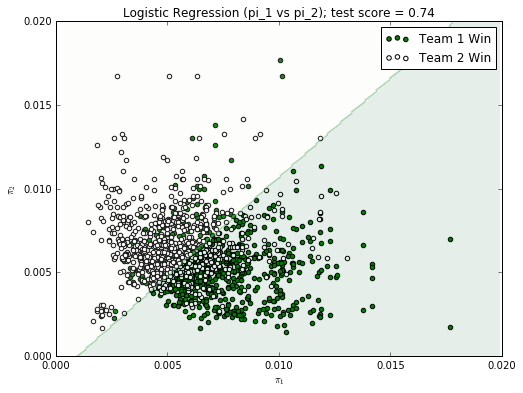

In [44]:
model = LogReg(C=1000000)
model.fit(train_X,train_y)
score = model.score(cross_X, cross_y)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_xlim(0, .02)
ax.set_ylim(0, .02)

print score
plot_decision_boundary(train_X.values, train_y.values, model, "Logistic Regression (pi_1 vs pi_2); test score = {}".format(round(score,2)), ax, bounds=(0, .02), poly_flag=False)

Issue with the plotting. Not sure why this is happening.

0.740554156171


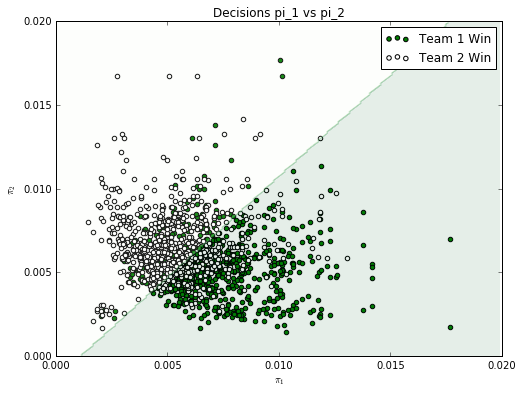

In [45]:
model2 = LDA()
model2.fit(train_X,train_y)
print model2.score(cross_X, cross_y)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_xlim(0, .02)
ax.set_ylim(0, .02)

plot_decision_boundary(train_X.values, train_y.values, model2, "Decisions pi_1 vs pi_2", ax, bounds=(0, .02), poly_flag=False)

0.740554156171


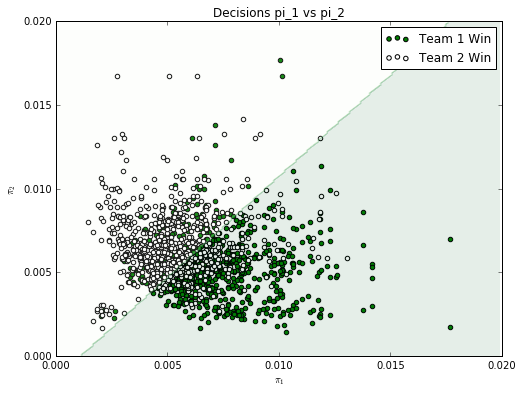

In [46]:
model2 = LDA()
model2.fit(train_X,train_y)
print model2.score(cross_X, cross_y)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_xlim(0, .02)
ax.set_ylim(0, .02)

plot_decision_boundary(train_X.values, train_y.values, model2, "Decisions pi_1 vs pi_2", ax, bounds=(0, .02), poly_flag=False)

0.725440806045


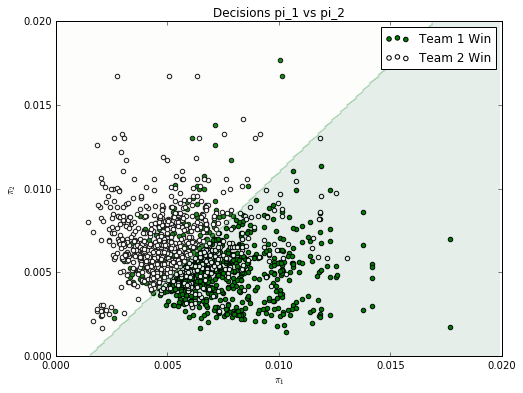

In [47]:
model3 = SVC(C=1000)
model3.fit(train_X,train_y)
print model3.score(cross_X, cross_y)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_xlim(0, .02)
ax.set_ylim(0, .02)

plot_decision_boundary(train_X.values, train_y.values, model3, "Decisions pi_1 vs pi_2", ax, bounds=(0, .02), poly_flag=False)

As we can see, just using the stationary distribution gives us good accuracy for our head to head model. While we will still try to add other predictors, it seems the markov chain steady state probability ranking does a nice job in picking the winner of games.